In [2]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import community as community_louvain
import leidenalg
import igraph as ig

In [3]:
# Load the country relationships file
file_path = "country_entities.csv"

try:
    df = pd.read_csv(file_path)
    print("File loaded successfully! Preview:\n")
    print(df.head())
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")

File loaded successfully! Preview:

   Country
0    China
1  Germany
2   France
3    China
4   France


In [4]:
# Display the first few rows
print("Columns:", df.columns)
print("First 10 rows:\n", df.head(10))

Columns: Index(['Country'], dtype='object')
First 10 rows:
    Country
0    China
1  Germany
2   France
3    China
4   France
5    China
6    India
7    China
8    China
9   Canada


In [5]:
# Creating artificial relationships by linking consecutive rows
df_relationships = df.copy()  # Copy original dataframe to avoid confusion
df_relationships['Country2'] = df_relationships['Country'].shift(-1)  # Shift column to create pairs

In [6]:
# Drop last row (as it will have NaN)
df_relationships = df_relationships.dropna()
# Rename columns for clarity
df_relationships.columns = ['Country1', 'Country2']
# Save the fixed data
df_relationships.to_csv("country_relationships.csv", index=False)

In [7]:
# Display first few relationships
print("Fixed data saved as 'country_relationships.csv'.")

Fixed data saved as 'country_relationships.csv'.


In [8]:
df_relationships.head(10)

,Country1,Country2
0,China,Germany
1,Germany,France
2,France,China
3,China,France
4,France,China
5,China,India
6,India,China
7,China,China
8,China,Canada
9,Canada,Russia


In [9]:
# Create an empty graph
G = nx.Graph()

In [10]:
# Add edges to the graph from dataframe
edges = list(zip(df_relationships['Country1'], df_relationships['Country2']))
G.add_edges_from(edges)

In [11]:
# Display basic graph info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Nodes:", list(G.nodes)[:10])  # Display first 10 nodes
print("Edges:", list(G.edges)[:10])  # Display first 10 edges

Number of nodes: 6
Number of edges: 8
Nodes: ['China', 'Germany', 'France', 'India', 'Canada', 'Russia']
Edges: [('China', 'Germany'), ('China', 'France'), ('China', 'India'), ('China', 'China'), ('China', 'Canada'), ('Germany', 'France'), ('France', 'Russia'), ('Canada', 'Russia')]


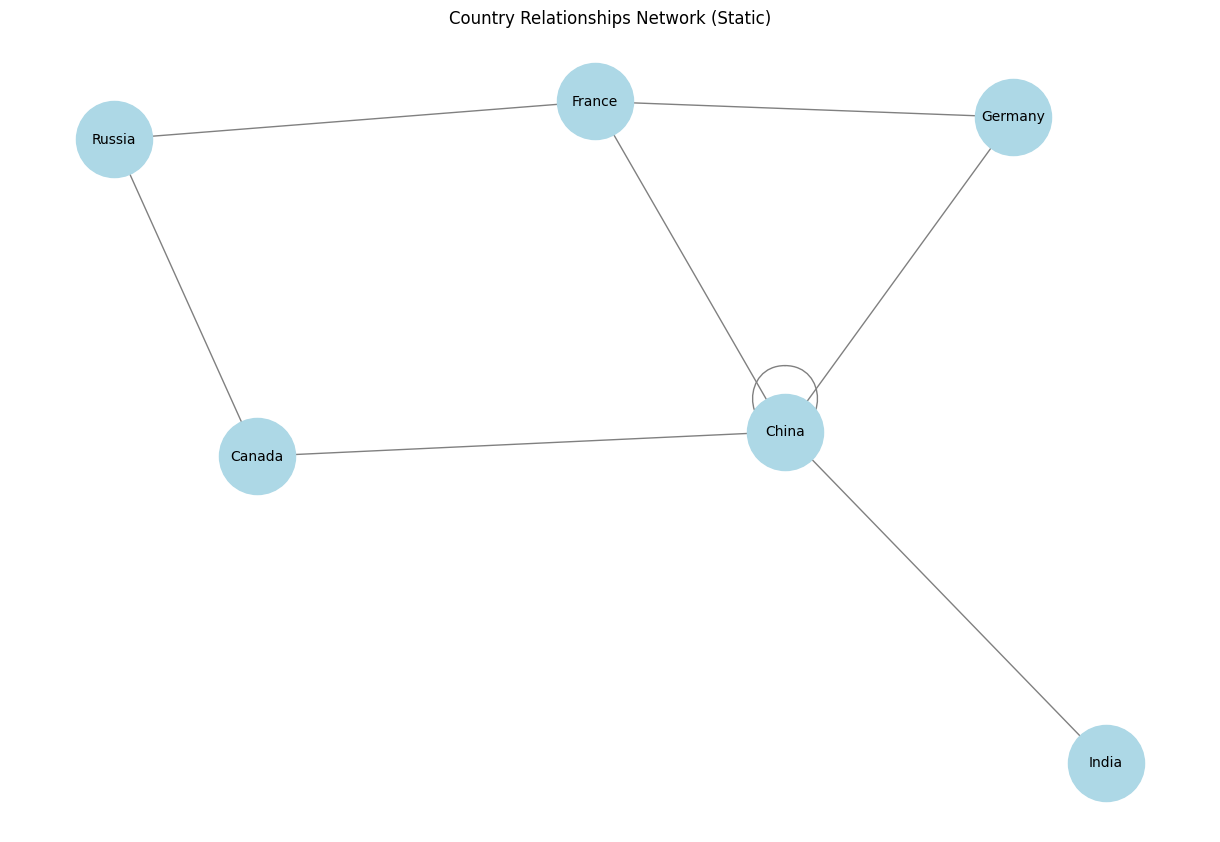

In [12]:
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
plt.title("Country Relationships Network (Static)")
plt.show()

In [13]:
import os

# Create an interactive PyVis network with in-line resources
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='in_line')

In [14]:
# Add nodes and edges
for node in G.nodes:
    net.add_node(node, label=node)

In [15]:
for edge in G.edges:
    net.add_edge(edge[0], edge[1])

In [16]:
# Save as an interactive HTML file with UTF-8 encoding
output_file = "interactive_network.html"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(net.generate_html())

In [17]:
print(f"Interactive network saved as '{output_file}'")

Interactive network saved as 'interactive_network.html'


In [18]:
# Convert NetworkX graph to iGraph format for Leiden algorithm
igraph_graph = ig.Graph.TupleList(G.edges(), directed=False)

In [19]:
# Apply Leiden algorithm
partition = leidenalg.find_partition(igraph_graph, leidenalg.ModularityVertexPartition)

In [20]:
# Assign community labels to nodes
community_dict = {node: membership for node, membership in zip(G.nodes(), partition.membership)}

In [21]:
# Set community labels as node attributes
nx.set_node_attributes(G, community_dict, "community")

In [22]:
# Print detected communities
print("Communities detected:", community_dict)

Communities detected: {'China': 1, 'Germany': 0, 'France': 0, 'India': 1, 'Canada': 2, 'Russia': 2}


In [23]:
import random

# Assign colors based on community groups
colors = ["red", "blue", "green", "purple", "orange", "yellow"]
node_colors = [colors[community_dict[node] % len(colors)] for node in G.nodes()]

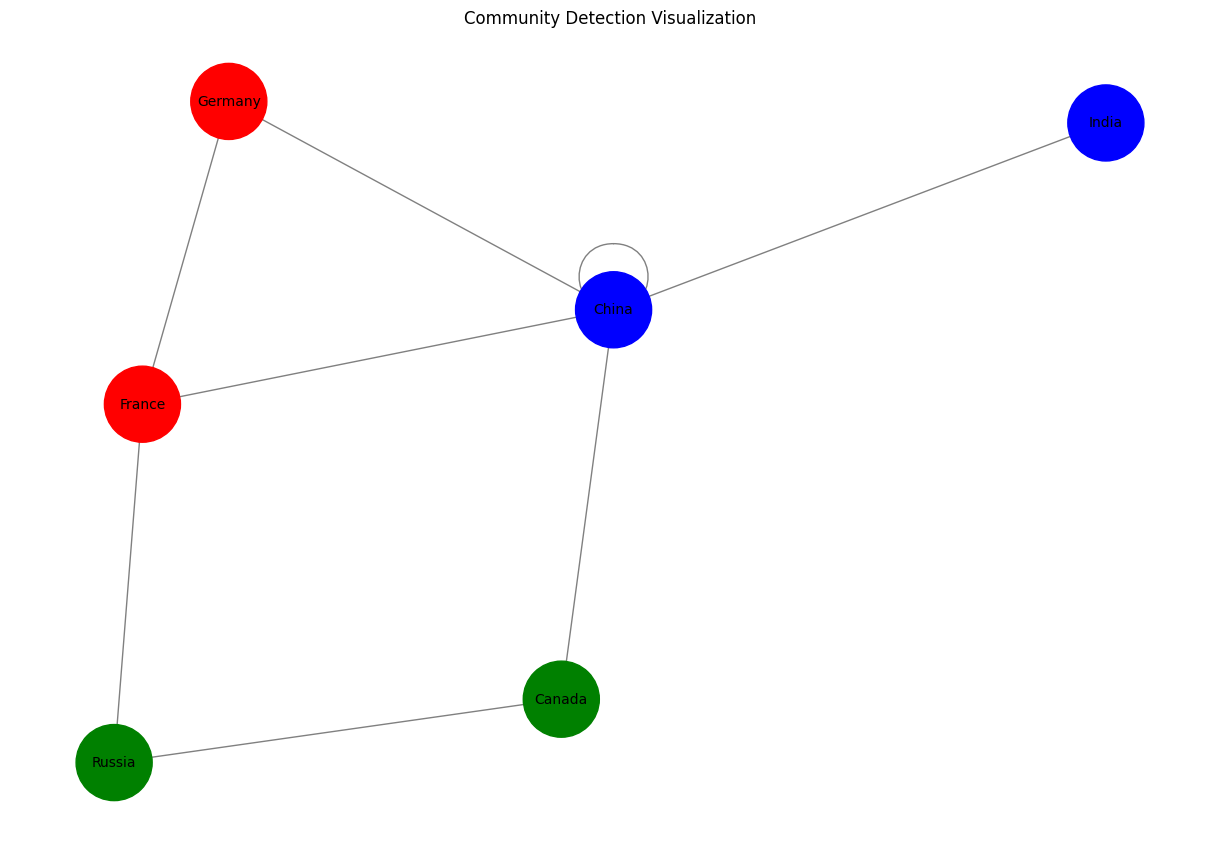

In [24]:
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color=node_colors, edge_color="gray", node_size=3000, font_size=10)
plt.title("Community Detection Visualization")
plt.show()

In [25]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

In [26]:
# Convert results to DataFrame
centrality_df = pd.DataFrame({
    "Country": list(G.nodes()),
    "Degree Centrality": [degree_centrality[node] for node in G.nodes()],
    "Closeness Centrality": [closeness_centrality[node] for node in G.nodes()],
    "Betweenness Centrality": [betweenness_centrality[node] for node in G.nodes()]
})

In [27]:
# Sort by Degree Centrality
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False)

In [28]:
print("Centrality Measures:")
print(centrality_df)

Centrality Measures:
   Country  Degree Centrality  Closeness Centrality  Betweenness Centrality
0    China                1.2              0.833333                    0.55
2   France                0.6              0.714286                    0.20
1  Germany                0.4              0.625000                    0.00
4   Canada                0.4              0.625000                    0.10
5   Russia                0.4              0.555556                    0.05
3    India                0.2              0.500000                    0.00


# Centrality Measures:
## Degree Centrality:

Degree centrality is a measure of the number of edges connected to a node. It indicates how well connected a node is in the network. Higher degree centrality suggests the node (country) is more central or influential in terms of direct connections.
Observation: China has the highest degree centrality in this example, implying it is the most connected country in the network.

## Closeness Centrality:

Closeness centrality measures how close a node is to all other nodes in the network. A higher closeness centrality means the node can reach other nodes more quickly.
Observation: China has the highest closeness centrality, indicating it can reach other countries in fewer steps, making it potentially more influential in terms of spreading information or influence.

## Betweenness Centrality:

Betweenness centrality measures the extent to which a node lies on the shortest path between other nodes. High betweenness centrality indicates that a node plays an important role in connecting other nodes.
Observation: China again has the highest betweenness centrality, suggesting it acts as a critical connector in the network, facilitating the flow of information or resources between other countries.

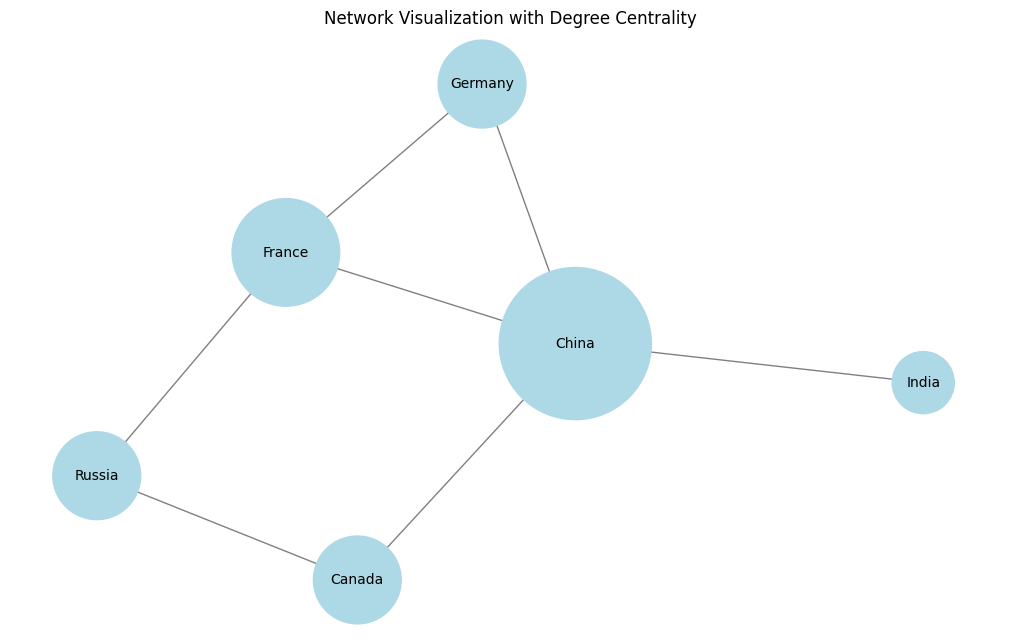

In [65]:
# Visualize Degree Centrality
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=[v * 10000 for v in degree_centrality.values()],
        with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
plt.title("Network Visualization with Degree Centrality")
plt.show()

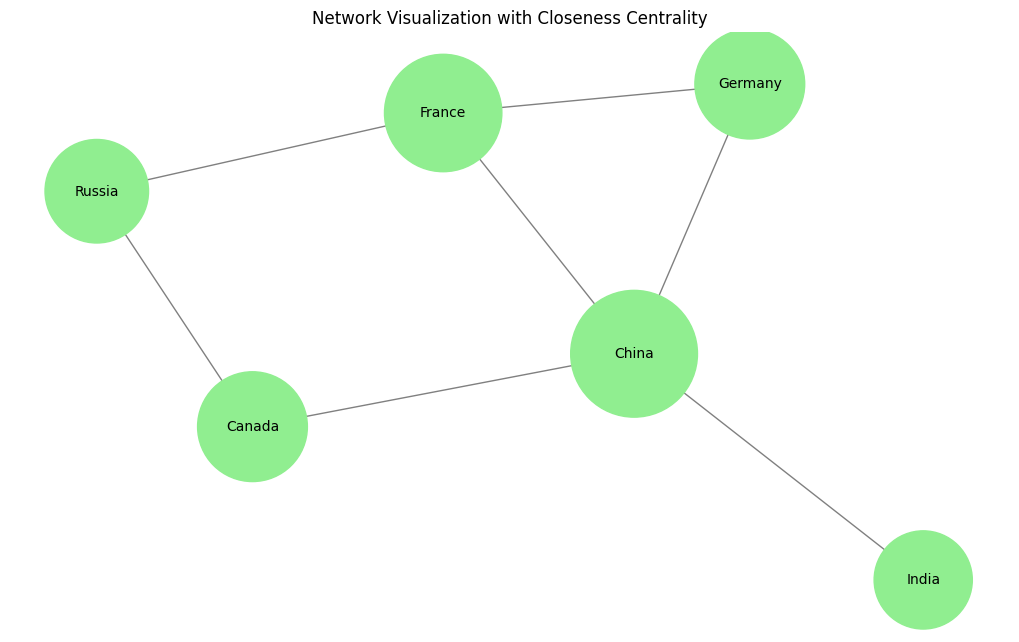

In [67]:
# Visualize Closeness Centrality
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=[v * 10000 for v in closeness_centrality.values()],
        with_labels=True, node_color='lightgreen', edge_color='gray', font_size=10)
plt.title("Network Visualization with Closeness Centrality")
plt.show()

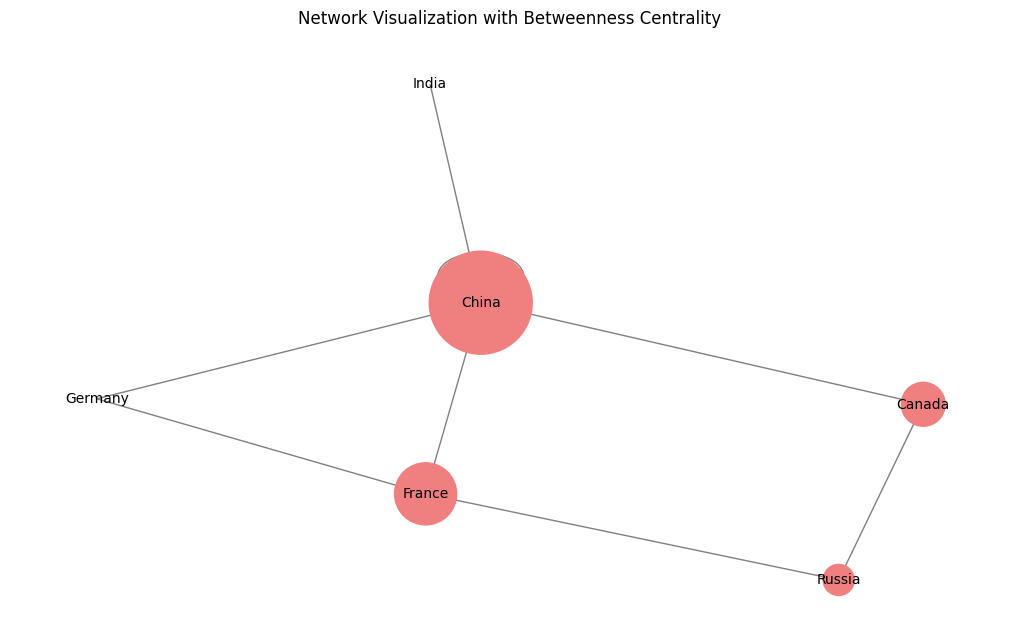

In [69]:
# Visualize Betweenness Centrality
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=[v * 10000 for v in betweenness_centrality.values()],
        with_labels=True, node_color='lightcoral', edge_color='gray', font_size=10)
plt.title("Network Visualization with Betweenness Centrality")
plt.show()

## Observation Summary:
China appears to be the most influential country in all three measures: it has the highest degree centrality, closeness centrality, and betweenness centrality.
France and Germany are also significant in terms of degree and closeness centrality, although not as much in betweenness centrality.
Countries with lower centrality scores, like India, suggest they are either less connected or farther from the rest of the network.

In [29]:
# Save to CSV
centrality_df.to_csv("centrality_measures.csv", index=False)
print("Centrality measures saved as 'centrality_measures.csv'")

Centrality measures saved as 'centrality_measures.csv'
